# Lecture7; Regularization

### Library

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers, initializers
import numpy as np
from matplotlib import pyplot as plt
import random

random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

### Data processing

In [2]:
(x_trainval, y_trainval), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_trainval, x_test = tf.cast(x_trainval, tf.float32), tf.cast(x_test, tf.float32)
y_trainval, y_test = tf.cast(y_trainval, tf.float32), tf.cast(y_test, tf.float32)

num_classes = 10
num_features = 784

x_trainval, x_test = tf.reshape(x_trainval,[-1, num_features]), tf.reshape(x_test, [-1, num_features])
x_trainval, x_test = x_trainval / 255., x_test / 255.

In [3]:
x = tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

s = np.random.permutation(10)
print(s)
x_2 = tf.gather(x, s)
y_2 = tf.gather(y, s)

x_train = x_2[:8]
y_train = y_2[:8]
x_val = x_2[8:]
y_val = y_2[8:]

print(x_train)
print(y_train)
print(x_val)
print(y_val)

[9 5 2 4 7 1 0 8 6 3]
tf.Tensor([9 5 2 4 7 1 0 8], shape=(8,), dtype=int32)
tf.Tensor([9 5 2 4 7 1 0 8], shape=(8,), dtype=int32)
tf.Tensor([6 3], shape=(2,), dtype=int32)
tf.Tensor([6 3], shape=(2,), dtype=int32)


In [4]:
indices = np.random.permutation(x_trainval.shape[0])
x_trainval = tf.gather(x_trainval, indices)
y_trainval = tf.gather(y_trainval, indices)
x_train = x_trainval[:50000] 
y_train = y_trainval[:50000]
x_val = x_trainval[50000:] 
y_val = y_trainval[50000:]

In [5]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(50000, 784)
(10000, 784)
(10000, 784)
(50000,)
(10000,)
(10000,)


In [6]:
batch_size = 200
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(50000).batch(batch_size).prefetch(1)

### Define functions for Training/Testing

In [7]:
def cross_entropy_loss(x, y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    return tf.reduce_mean(loss)

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    
def Train_model(model, lr, epo, print_loss=True, plot_graph=True):
    step_l = []
    loss_l = []
    
    optimizer = tf.optimizers.SGD(lr, momentum=0.9)
    
    for epoch in range(1,epo+1):
        for step, (batch_x, batch_y) in enumerate(train_data, 1):
            with tf.GradientTape() as g:
                pred = model(batch_x, is_training=True)
                loss = cross_entropy_loss(pred, batch_y)

            trainable_variables = model.trainable_variables
            gradients = g.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))
            
            if plot_graph:
                if step % 50 == 0:
                    step_l.append((epoch-1)*300 + step)
                    loss_l.append(loss.numpy())
        if print_loss:
            acc = accuracy(model(x_test), y_test)
            print("epoch: ", epoch, ", loss: ", loss.numpy(), "acc: ", acc)
    
    if plot_graph:
        plt.plot(step_l, loss_l)
    return model

In [8]:
class NeuralNet(Model): # Regularization skill을 추가하지 않은 기본 뉴럴네트워크 구조
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        """
        code
        """

    def call(self, x, is_training=False):
        pass
        """
        code
        """

## Early stopping

In [9]:
import sys
import copy

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.shuffle(10000).batch(batch_size).prefetch(1)

def early_stopping(model, lr):
    el = []
    vll = []
    
    p = 5 #patience
    i = 0
    j = 0
    v = sys.float_info.max  # 강의자료의 알고리즘에서는 무한대 값을 넣으라고 돼있음. 컴퓨터에서는 무한값을 넣지 못하므로
                            # float형 데이터가 가질 수 있는 가장 큰 값 집어넣어줌
#     v = 100 # 이렇게 코딩해도 무방.. error를 accuracy(%)로 계산하고 있으므로, 사실 100이면 제일 큰 값이다.
    model_s = copy.deepcopy(model) # theta_star 대신, 파라미터를 포함하고 있는 모델 째로 복사해줬음
                                   # model_s = model이라고 적어주면, model과 똑같은 정보를 담고 있는 model_s가 새로 생기는게 아니라,
                                   # 그냥 model이라는 인스턴스에 model_s라는 이름이 하나 더 생기는 것처럼 돼서, (보다 정확한 설명은 'python class 복사' 등의 키워드로 검색해보시길 권장드립니다!)
                                   # 의도와는 다르게 model이 가진 인수의 값이 변하면 model_s도 따라서 바뀌게 된다.
                                   # 때문에 deepcopy를 통해 현재 model이 가지고 있는 정보는 그대로 담고 있되, 따로따로 취급되는 새로운 인스턴스를 만들어준 것
                                   # 즉, 이렇게 정의해야 model의 값이 변해도 model_s의 값은 유지된다.
    i_s = i #i_star
    
    while j < p : # j는 가장 작은 error가 갱신된 이후, 그보다 더 작은 에러가 나오지 않은 epoch 수를 센다. 이 횟수가 미리 정해둔 patience 값과 같게 되면 학습 중단하고, 가장 작은 error 보였던 모델 사용
        Train_model(model, lr, 1, print_loss=False, plot_graph=False) 

        acc = accuracy(model(x_val), y_val) * 100. # validation data를 이용해 현재의 accuracy 측정, *100 을 해서 (%)단위로 볼 수 있게 계산
        tmp_v = 100. - acc # v'
        i += 1
        print("epoch reached ", i, ": current_val_error = ", tmp_v, "(%) / smallest_error = ", v, "(%)") #epoch마다 현재 error 정보 출력
        el.append(i) # 그래프 출력을 위한 정보 담기
        vll.append(tmp_v) # 그래프 출력을 위한 정보 담기 2
                               
        if tmp_v < v : # 가장 작은 에러값이 갱신 되었을 때
            j = 0                          # j는 0으로 리셋된다. 이 때부터 다시 가장 작은 에러가 갱신되지 않은 횟수 카운트 시작
            model_s = copy.deepcopy(model) # 제일 좋은 모델(model_s)은 현재의 모델로 대체
            i_s = i                        # best_epoch(i_s)도 현재의 epoch으로 대체
            v = tmp_v                      # 가장 작은 에러값을 담아놓는 변수에 현재 에러값 넣어줌
        else : # 현재 에러 값(tmp_v)이 가장 작은 에러(v)보다 크지 않을 때
            j += 1                         # j의 값을 1 늘림, 이 값이 p(patience)와 같아지면 학습 중단
    
    # 학습이 중단되고 나면,
    plt.plot(el, vll) # 그래프 출력
    print("best_epoch =", i_s) # i_s에 저장된 값 best_epoch으로 출력
    return model_s, i_s # 가장 좋은 epoch 값과 가장 좋은 모델 리턴(바로 테스트에 사용가능)

epoch reached  1 : current_val_error =  5.879998207092285 (%) / smallest_error =  1.7976931348623157e+308 (%)
epoch reached  2 : current_val_error =  4.490000009536743 (%) / smallest_error =  5.879998207092285 (%)
epoch reached  3 : current_val_error =  3.6800026893615723 (%) / smallest_error =  4.490000009536743 (%)
epoch reached  4 : current_val_error =  3.2599985599517822 (%) / smallest_error =  3.6800026893615723 (%)
epoch reached  5 : current_val_error =  3.0600011348724365 (%) / smallest_error =  3.2599985599517822 (%)
epoch reached  6 : current_val_error =  2.920001745223999 (%) / smallest_error =  3.0600011348724365 (%)
epoch reached  7 : current_val_error =  2.8100013732910156 (%) / smallest_error =  2.920001745223999 (%)
epoch reached  8 : current_val_error =  2.6600003242492676 (%) / smallest_error =  2.8100013732910156 (%)
epoch reached  9 : current_val_error =  2.590000629425049 (%) / smallest_error =  2.6600003242492676 (%)
epoch reached  10 : current_val_error =  2.60000

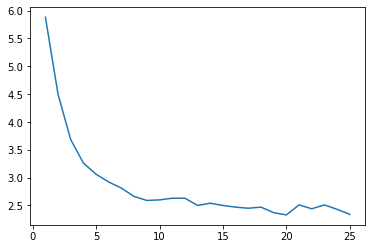

In [10]:
neural_net = NeuralNet()
neural_net, best_epoch = early_stopping(neural_net, 0.01)

In [11]:
n_acc = accuracy(neural_net(x_test), y_test)
print("test accuracy =", n_acc) # 기본 성능, 앞으로 Regularization skill을 적용했을 때 이 부분의 성능과 비교해볼 것

test accuracy = 0.9779


## Regularization
### weight decay

regularizer 종류 : https://www.tensorflow.org/api_docs/python/tf/keras/regularizers

In [12]:
class WD_NeuralNet(Model):
    def __init__(self):
        super(WD_NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer="""fill here""")
        self.bn1 = layers.BatchNormalization()
        self.ac1 = layers.Activation(tf.nn.relu)
        self.fc2 = layers.Dense(256, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer="""fill here""")
        self.bn2 = layers.BatchNormalization()
        self.ac2 = layers.Activation(tf.nn.relu)
        self.out = layers.Dense(num_classes, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer="""fill here""")

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.bn2(x, training=is_training)
        x = self.ac2(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

epoch reached  1 : current_val_error =  5.669999122619629 (%) / smallest_error =  1.7976931348623157e+308 (%)
epoch reached  2 : current_val_error =  3.8999974727630615 (%) / smallest_error =  5.669999122619629 (%)
epoch reached  3 : current_val_error =  3.609997034072876 (%) / smallest_error =  3.8999974727630615 (%)
epoch reached  4 : current_val_error =  2.9799997806549072 (%) / smallest_error =  3.609997034072876 (%)
epoch reached  5 : current_val_error =  3.0300021171569824 (%) / smallest_error =  2.9799997806549072 (%)
epoch reached  6 : current_val_error =  2.679997682571411 (%) / smallest_error =  2.9799997806549072 (%)
epoch reached  7 : current_val_error =  2.6899993419647217 (%) / smallest_error =  2.679997682571411 (%)
epoch reached  8 : current_val_error =  2.439999580383301 (%) / smallest_error =  2.679997682571411 (%)
epoch reached  9 : current_val_error =  2.549999952316284 (%) / smallest_error =  2.439999580383301 (%)
epoch reached  10 : current_val_error =  2.53999829

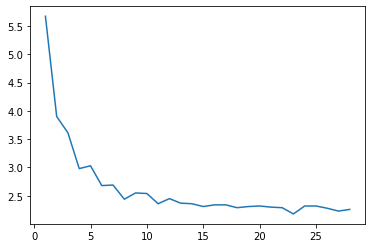

In [13]:
wd_nn = WD_NeuralNet()
wd_nn, wd_best_epoch = early_stopping(wd_nn, 0.01)

In [14]:
wd_acc = accuracy(wd_nn(x_test), y_test)
print("test accuracy =", wd_acc)

test accuracy = 0.9774


### drop out 

In [15]:
class DO_NeuralNet(Model):
    def __init__(self):
        super(DO_NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, kernel_initializer = initializers.GlorotNormal())
        self.bn1 = layers.BatchNormalization()
        self.ac1 = layers.Activation(tf.nn.relu)
        self.do1 = """fill here"""
        self.fc2 = layers.Dense(256, kernel_initializer = initializers.GlorotNormal())
        self.bn2 = layers.BatchNormalization()
        self.ac2 = layers.Activation(tf.nn.relu)
        self.do2 = """fill here"""
        self.out = layers.Dense(num_classes, kernel_initializer = initializers.GlorotNormal())

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = self.ac1(x)
        x = self.do1(x, training=is_training)
        x = self.fc2(x)
        x = self.bn2(x, training=is_training)
        x = self.ac2(x)
        x = self.do2(x, training=is_training)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

epoch reached  1 : current_val_error =  8.639997243881226 (%) / smallest_error =  1.7976931348623157e+308 (%)
epoch reached  2 : current_val_error =  7.039999961853027 (%) / smallest_error =  8.639997243881226 (%)
epoch reached  3 : current_val_error =  6.349998712539673 (%) / smallest_error =  7.039999961853027 (%)
epoch reached  4 : current_val_error =  5.669999122619629 (%) / smallest_error =  6.349998712539673 (%)
epoch reached  5 : current_val_error =  4.919999837875366 (%) / smallest_error =  5.669999122619629 (%)
epoch reached  6 : current_val_error =  4.7299981117248535 (%) / smallest_error =  4.919999837875366 (%)
epoch reached  7 : current_val_error =  4.559999704360962 (%) / smallest_error =  4.7299981117248535 (%)
epoch reached  8 : current_val_error =  4.400002956390381 (%) / smallest_error =  4.559999704360962 (%)
epoch reached  9 : current_val_error =  4.2900025844573975 (%) / smallest_error =  4.400002956390381 (%)
epoch reached  10 : current_val_error =  3.869998455047

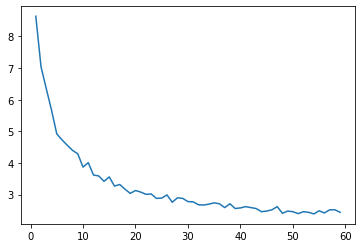

In [16]:
do_nn = DO_NeuralNet()
do_nn, do_best_epoch = early_stopping(do_nn, 0.01)

In [17]:
do_acc = accuracy(do_nn(x_test), y_test)
print("test accuracy =", do_acc)

test accuracy = 0.976


In [18]:
# Create TF Model.
class DOwoBN_NeuralNet(Model):
    # Set layers.
    def __init__(self):
        super(DOwoBN_NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01), activation=tf.nn.relu, kernel_initializer = initializers.GlorotNormal())
        self.do1 = layers.Dropout(rate=0.5)
        self.fc2 = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01), activation=tf.nn.relu, kernel_initializer = initializers.GlorotNormal())
        self.do2 = layers.Dropout(rate=0.5)
        self.out = layers.Dense(num_classes, kernel_initializer = initializers.he_normal())

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.do1(x, training=is_training)
        x = self.fc2(x)
        x = self.do2(x, training=is_training)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

epoch reached  1 : current_val_error =  10.850000381469727 (%) / smallest_error =  1.7976931348623157e+308 (%)
epoch reached  2 : current_val_error =  8.499997854232788 (%) / smallest_error =  10.850000381469727 (%)
epoch reached  3 : current_val_error =  7.319998741149902 (%) / smallest_error =  8.499997854232788 (%)
epoch reached  4 : current_val_error =  6.639999151229858 (%) / smallest_error =  7.319998741149902 (%)
epoch reached  5 : current_val_error =  5.91999888420105 (%) / smallest_error =  6.639999151229858 (%)
epoch reached  6 : current_val_error =  5.419999361038208 (%) / smallest_error =  5.91999888420105 (%)
epoch reached  7 : current_val_error =  5.010002851486206 (%) / smallest_error =  5.419999361038208 (%)
epoch reached  8 : current_val_error =  4.680001735687256 (%) / smallest_error =  5.010002851486206 (%)
epoch reached  9 : current_val_error =  4.610002040863037 (%) / smallest_error =  4.680001735687256 (%)
epoch reached  10 : current_val_error =  4.309999942779541

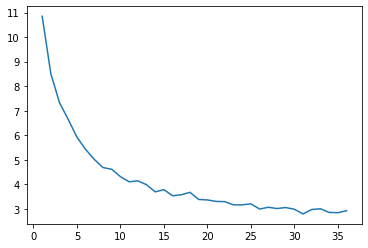

In [19]:
dowobn_nn = DOwoBN_NeuralNet()
dowobn_nn, dowobn_best_epoch = early_stopping(dowobn_nn, 0.01)

In [20]:
dowobn_acc = accuracy(dowobn_nn(x_test), y_test)
print("test accuracy =", dowobn_acc)

test accuracy = 0.9728


### model Ensembles

In [21]:
pred = (neural_net(x_test, is_training=False) + wd_nn(x_test, is_training=False) + do_nn(x_test, is_training=False))/3
ensem_acc = accuracy(pred, y_test)

print(ensem_acc)

0.9815


In [22]:
## 최종 결과 종합 비교  ##어떤 스킬이 주로 성능향상 효과를 보이는 경향이 있다고 해도 항상 동일하게 그 성능 향상 효과를 관측하기는 어려울 수 있음
print(n_acc) # 기본 뉴럴네트워크의 정확도
print(wd_acc) # 기본 뉴럴네트워크에 weight decay 적용한 정확도
print(do_acc) # 기본 뉴럴네트워크에 dropout 적용한 정확도
              # (기본 뉴럴네트워크에 비해 성능 저하 일어날 수 있음 
              # batch normalization이 주던 성능 향상 효과를 dropout과 함께 적용해 오히려 깎아먹음)
              # (batch norm과 dropout은 같이 쓰지 않는다!)
print(dowobn_acc) # 기본 뉴럴네트워크에서 batch normalization 빼고 dropout 적용한 정확도
                  # 즉, 현재 나온 정확도는 기본 뉴럴네트워크에서 batch normalization의 성능향상 효과를 빼고 dropout 적용한 정확도
                  # 그러므로 fair하게 dropout의 성능향상효과를 확인하기 위해서는 batchnorm을 적용하지 않은 네트워크의 정확도와 비교해야함
                  # (보통은 dropout에 비해 batch normalization이 주는 성능향상 효과가 커서, dowobn_acc이 n_acc보다 낮을 수 있음)
print(ensem_acc) #앞서 학습 시킨 neural_net, wd_nn, dobn_nn 네트워크(Top3 정확도를 가진 네트워크)로 ensemble한 정확도

0.9779
0.9774
0.976
0.9728
0.9815
